# Random Forest Model

So far decision trees are the most accurate models in predicting the classes. Random Forest and Gradient Boosted trees perform somewhat similarly.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
import matplotlib.cm as cmx
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from Notebook_helpers import load_data
from Notebook_helpers.modeling_helpers import *

%matplotlib inline

## Read in Data

In [3]:
df, train, test = load_data.load_coral_data(complete=True, CV=True, convert_to_categorical=True)
print(train.shape)

(496, 44)


In [4]:
train_X, train_y, pred_names = load_data.get_features_and_response(train)
pred_names

Index(['Effluent', 'Sedimentation', 'New_Development', 'Habitat_Modification',
       'Invasive_Algae', 'Fishing_Comm_Total', 'Fishing_NonComm_Boat_Total',
       'Fishing_NonComm_Shore_Line', 'Fishing_NonComm_Shore_Net',
       'Fishing_NonComm_Shore_Spear', 'SST_CLIM_M', 'SST_STD', 'CHL_CLIM_M',
       'CHL_ANOM_F', 'PAR_CLIM_M', 'PAR_STD', 'WAV_CLIM_M', 'WAV_ANOM_F',
       'Complexity', 'Depth'],
      dtype='object')

# Cross-Validation

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, zero_one_loss
import time
num_trees = [1, 10, 50, 100, 150, 200, 250, 300]
depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
hyperparameters = dict(n_estimators=num_trees, max_depth=depth)

begin = time.time()
clf = GridSearchCV(sklearn.ensemble.RandomForestClassifier(random_state=229), 
                  hyperparameters, cv=5, verbose=1, iid=False,
                  scoring = make_scorer(metrics.f1_score, average='micro', greater_is_better=True),
                  return_train_score=True)
best_model = clf.fit(train_X, train_y)

print("That took {} seconds".format(time.time() - begin))

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   48.9s finished


That took 49.20406174659729 seconds


In [6]:
# # Best Model is the model picked with the optimal C retrained on the
# # entire training data.

print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])

Best n_estimators: 250
Best max_depth: 9


### Plot CV Results

In [7]:
# from scikit-learn, "Demonstration of multi-metric evaluation on cross_val_score and GridSearchCV" 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
results = clf.cv_results_

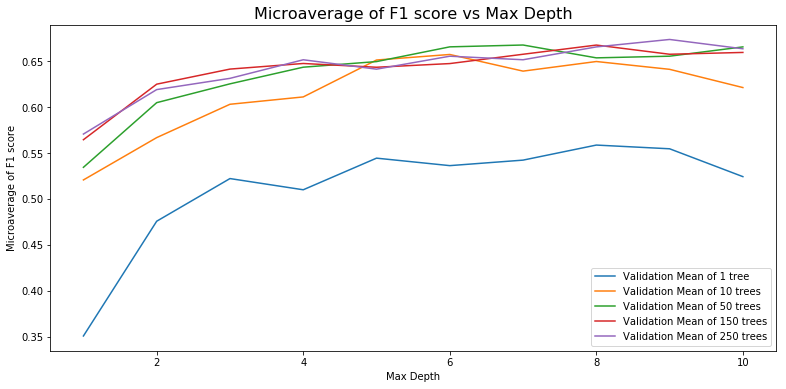

In [9]:
plt.figure(figsize=(13, 6))
plt.title("Microaverage of F1 score vs Max Depth",
          fontsize=16)

plt.xlabel("Max Depth")
plt.ylabel("Microaverage of F1 score")

ax = plt.gca()

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_max_depth'].data, dtype=float)
X_axis_unique = np.unique(X_axis)

sample_score_mean = results['mean_test_score']
# sample_score_std = results['std_test_score']

train_score_mean = results['mean_train_score']

plt.plot(X_axis_unique, sample_score_mean[range(0,80,8)], label='Validation Mean of 1 tree')
plt.plot(X_axis_unique, sample_score_mean[range(1,81,8)], label='Validation Mean of 10 trees')
plt.plot(X_axis_unique, sample_score_mean[range(2,82,8)], label='Validation Mean of 50 trees')
plt.plot(X_axis_unique, sample_score_mean[range(4,84,8)], label='Validation Mean of 150 trees')
plt.plot(X_axis_unique, sample_score_mean[range(6,86,8)], label='Validation Mean of 250 trees')

plt.legend()

plt.grid(False)

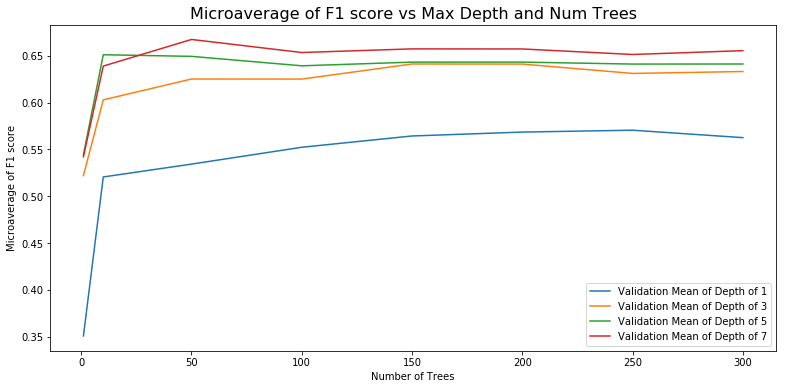

In [10]:
plt.figure(figsize=(13, 6))
plt.title("Microaverage of F1 score vs Max Depth and Num Trees",
          fontsize=16)

plt.xlabel("Number of Trees")
plt.ylabel("Microaverage of F1 score")

ax = plt.gca()
# plt.xscale("log")
# ax.set_xlim(C[0], C[-1])

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_n_estimators'].data, dtype=float)
X_axis_unique = np.unique(X_axis)

sample_score_mean = results['mean_test_score']

train_score_mean = results['mean_train_score']

plt.plot(X_axis_unique, sample_score_mean[0:8], label='Validation Mean of Depth of 1')
plt.plot(X_axis_unique, sample_score_mean[16:24], label='Validation Mean of Depth of 3')
plt.plot(X_axis_unique, sample_score_mean[32:40], label='Validation Mean of Depth of 5')
plt.plot(X_axis_unique, sample_score_mean[48:56], label='Validation Mean of Depth of 7')

plt.legend()

plt.grid(False)

# Train best model

In [11]:
df, train, val, test = load_data.load_coral_data(complete=True, CV=False, convert_to_categorical=True)
print(train.shape)
print(val.shape)

(396, 44)
(100, 44)


In [13]:
train_X, train_y, pred_names = load_data.get_features_and_response(train)
val_X, val_y, pred_names = load_data.get_features_and_response(val)
pred_names

Index(['Effluent', 'Sedimentation', 'New_Development', 'Habitat_Modification',
       'Invasive_Algae', 'Fishing_Comm_Total', 'Fishing_NonComm_Boat_Total',
       'Fishing_NonComm_Shore_Line', 'Fishing_NonComm_Shore_Net',
       'Fishing_NonComm_Shore_Spear', 'SST_CLIM_M', 'SST_STD', 'CHL_CLIM_M',
       'CHL_ANOM_F', 'PAR_CLIM_M', 'PAR_STD', 'WAV_CLIM_M', 'WAV_ANOM_F',
       'Complexity', 'Depth'],
      dtype='object')

In [14]:
rf_model = sklearn.ensemble.RandomForestClassifier(n_estimators=250, max_depth=9, random_state=229)
rf_model.fit(train_X, train_y)

estimates = rf_model.predict(val_X)

#### evaluate performance

Misclassified samples: 32
Classification Report:
              precision    recall  f1-score   support

           1       0.72      0.81      0.76        26
           2       0.68      0.68      0.68        28
           3       0.62      0.72      0.67        25
           5       0.71      0.48      0.57        21

   micro avg       0.68      0.68      0.68       100
   macro avg       0.68      0.67      0.67       100
weighted avg       0.68      0.68      0.68       100



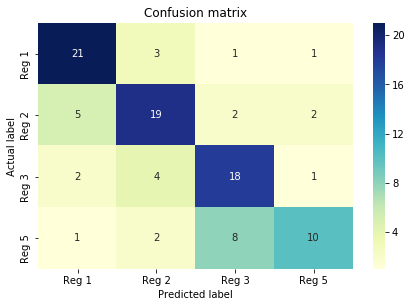

In [15]:
evaluate_performance(val_y, estimates)

# -------------------------------------------------------------------------------------------

# Try adding new features

## Read in Data

In [16]:
df, train, test = load_data.load_coral_data(complete=True, CV=True, convert_to_categorical=True)
print(train.shape)

(496, 44)


In [17]:
train_X, train_y, pred_names = load_data.get_features_and_response(train, True)
pred_names

Index(['Effluent', 'Sedimentation', 'New_Development', 'Habitat_Modification',
       'Invasive_Algae', 'Fishing_Comm_Total', 'Fishing_NonComm_Boat_Total',
       'Fishing_NonComm_Shore_Line', 'Fishing_NonComm_Shore_Net',
       'Fishing_NonComm_Shore_Spear', 'SST_CLIM_M', 'SST_STD', 'CHL_CLIM_M',
       'CHL_ANOM_F', 'PAR_CLIM_M', 'PAR_STD', 'WAV_CLIM_M', 'WAV_ANOM_F',
       'Complexity', 'Depth', 'sqrt_power_x_compexity', 'log_power_over_depth',
       'complexity_over_depth', 'Irradiance_x_inv_algae', 'both_anomolies'],
      dtype='object')

# Cross-Validation

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, zero_one_loss
import time
num_trees = [1, 10, 50, 100, 150, 200, 250, 300]
depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
hyperparameters = dict(n_estimators=num_trees, max_depth=depth)

begin = time.time()
clf = GridSearchCV(sklearn.ensemble.RandomForestClassifier(random_state=229), 
                  hyperparameters, cv=5, verbose=1, iid=False,
                  scoring = make_scorer(metrics.f1_score, average='micro', greater_is_better=True),
                  return_train_score=True)
best_model = clf.fit(train_X, train_y)

print("That took {} seconds".format(time.time() - begin))

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


That took 57.332517862319946 seconds


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   57.2s finished


In [19]:
# # Best Model is the model picked with the optimal C retrained on the
# # entire training data.

print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])

Best n_estimators: 100
Best max_depth: 10


### Plot CV Results

In [20]:
# from scikit-learn, "Demonstration of multi-metric evaluation on cross_val_score and GridSearchCV" 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
results = clf.cv_results_

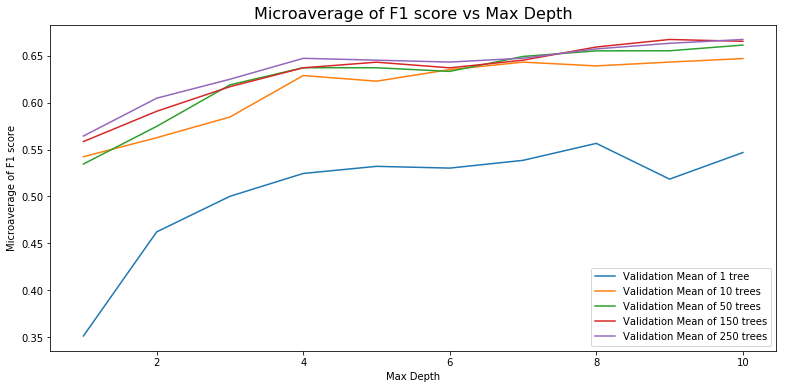

In [21]:
plt.figure(figsize=(13, 6))
plt.title("Microaverage of F1 score vs Max Depth",
          fontsize=16)

plt.xlabel("Max Depth")
plt.ylabel("Microaverage of F1 score")

ax = plt.gca()

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_max_depth'].data, dtype=float)
X_axis_unique = np.unique(X_axis)

sample_score_mean = results['mean_test_score']
# sample_score_std = results['std_test_score']

train_score_mean = results['mean_train_score']

plt.plot(X_axis_unique, sample_score_mean[range(0,80,8)], label='Validation Mean of 1 tree')
plt.plot(X_axis_unique, sample_score_mean[range(1,81,8)], label='Validation Mean of 10 trees')
plt.plot(X_axis_unique, sample_score_mean[range(2,82,8)], label='Validation Mean of 50 trees')
plt.plot(X_axis_unique, sample_score_mean[range(4,84,8)], label='Validation Mean of 150 trees')
plt.plot(X_axis_unique, sample_score_mean[range(6,86,8)], label='Validation Mean of 250 trees')

plt.legend()

plt.grid(False)

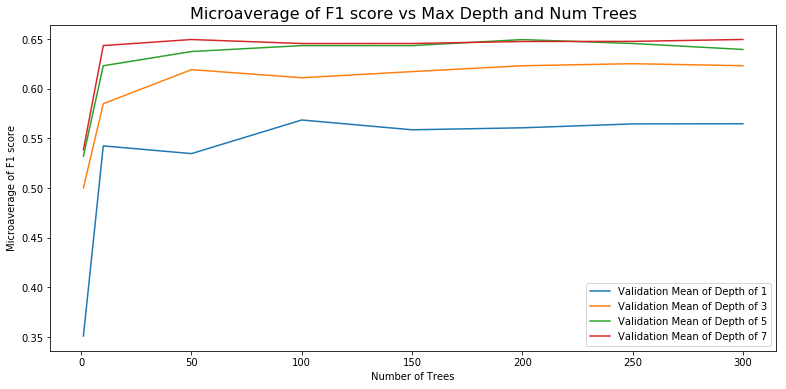

In [22]:
plt.figure(figsize=(13, 6))
plt.title("Microaverage of F1 score vs Max Depth and Num Trees",
          fontsize=16)

plt.xlabel("Number of Trees")
plt.ylabel("Microaverage of F1 score")

ax = plt.gca()
# plt.xscale("log")
# ax.set_xlim(C[0], C[-1])

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_n_estimators'].data, dtype=float)
X_axis_unique = np.unique(X_axis)

sample_score_mean = results['mean_test_score']

train_score_mean = results['mean_train_score']

plt.plot(X_axis_unique, sample_score_mean[0:8], label='Validation Mean of Depth of 1')
plt.plot(X_axis_unique, sample_score_mean[16:24], label='Validation Mean of Depth of 3')
plt.plot(X_axis_unique, sample_score_mean[32:40], label='Validation Mean of Depth of 5')
plt.plot(X_axis_unique, sample_score_mean[48:56], label='Validation Mean of Depth of 7')

plt.legend()

plt.grid(False)

# Train best model and test on validation set

In [23]:
df, train, val, test = load_data.load_coral_data(complete=True, CV=False, convert_to_categorical=True)
print(train.shape)
print(val.shape)

(396, 44)
(100, 44)


In [24]:
train_X, train_y, pred_names = load_data.get_features_and_response(train, True)
val_X, val_y, pred_names = load_data.get_features_and_response(val, True)
pred_names

Index(['Effluent', 'Sedimentation', 'New_Development', 'Habitat_Modification',
       'Invasive_Algae', 'Fishing_Comm_Total', 'Fishing_NonComm_Boat_Total',
       'Fishing_NonComm_Shore_Line', 'Fishing_NonComm_Shore_Net',
       'Fishing_NonComm_Shore_Spear', 'SST_CLIM_M', 'SST_STD', 'CHL_CLIM_M',
       'CHL_ANOM_F', 'PAR_CLIM_M', 'PAR_STD', 'WAV_CLIM_M', 'WAV_ANOM_F',
       'Complexity', 'Depth', 'sqrt_power_x_compexity', 'log_power_over_depth',
       'complexity_over_depth', 'Irradiance_x_inv_algae', 'both_anomolies'],
      dtype='object')

In [25]:
rf_model = sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_depth=10, random_state=229)
rf_model.fit(train_X, train_y)

estimates = rf_model.predict(val_X)

#### evaluate performance

Misclassified samples: 31
Classification Report:
              precision    recall  f1-score   support

           1       0.78      0.81      0.79        26
           2       0.71      0.71      0.71        28
           3       0.61      0.68      0.64        25
           5       0.65      0.52      0.58        21

   micro avg       0.69      0.69      0.69       100
   macro avg       0.69      0.68      0.68       100
weighted avg       0.69      0.69      0.69       100



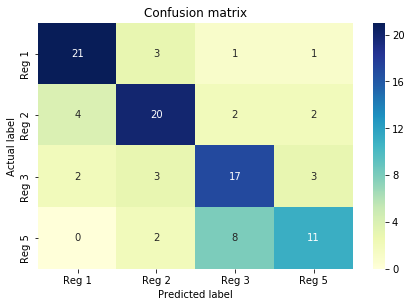

In [26]:
evaluate_performance(val_y, estimates)